# Chanterelle Finder
### Nancy Williams



In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import richdem as rd
from osgeo import gdal

matplotlib.rcParams['figure.figsize'] = (8, 5.5)

In [9]:
# Users define some inputs
home = '400 Broad St, Seattle, WA 98109' # your home address. This is the space needle.
miles_drive = 60 # miles you're willing to drive from your home
distance_hike = 5280 # how many feet are you willing to walk (climb? crawl over stumps and logs) to get to your chanterelle honey hole?
elevation_min = 1000
elevation_max = 2000 # we know that chanterelles can grow higher than 2000 ft elevation, but 1000-2000 is the sweet spot
m_ft = 0.3048 # Conversion from meters to feet

## Bring in elevation data
To get elevation data we will use a python toolbox called elevation:

https://pypi.org/project/elevation/

In [3]:
dem_path = os.path.join(os.getcwd(), 'NWWashington.tif')
elevation.clip(bounds=(-123.5, 46.5, -121, 48), output=dem_path)

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.df2afd06313447188ec3339ad0b622ef.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -123.5 48.0 -121.0 46.5 SRTM1.df2afd06313447188ec3339ad0b622ef.vrt /Users/williams/Documents/NancyPy/Chanterelles/NWWashington.tif
rm -f SRTM1.df2afd06313447188ec3339ad0b622ef.vrt


Intro to gdal (it's finnicky so for the meantime we will work around it): https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-1-a3253eb96082

In [4]:
#gdalinfo('NWWashington.tif')

/var/folders/77/krt31b_92xg9grw6m3r25r380000mn/T/ipykernel_99981/3305019598.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_array = gdal_data.ReadAsArray().astype(np.float)


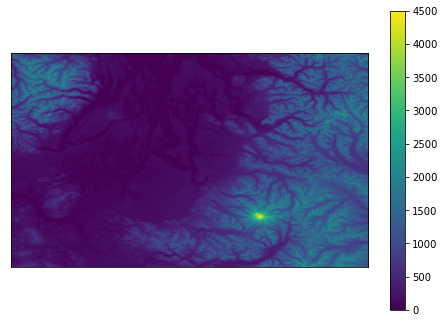

In [25]:
# Another example: https://www.earthdatascience.org/tutorials/python/elevation/
filename = 'NWWashington.tif'
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)
data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan
    
NWWA_dem = rd.rdarray(data_array, no_data=-9999)
plt.imshow(NWWA_dem,interpolation='none', vmin=0, vmax = 4500)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Filter out slopes that are too low or high in elevation

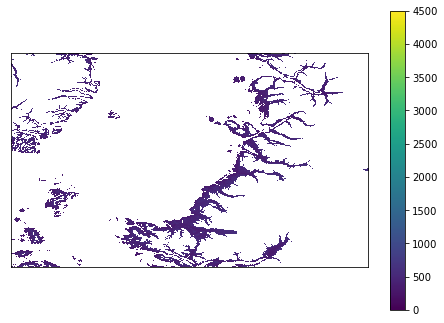

In [24]:
NWWA_dem_subset = np.ma.masked_where((NWWA_dem<elevation_min*m_ft) | 
                                    (NWWA_dem>elevation_max*m_ft), NWWA_dem)
plt.imshow(NWWA_dem_subset, interpolation='none', vmin=0, vmax = 4500)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Calculate the slope

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.909636


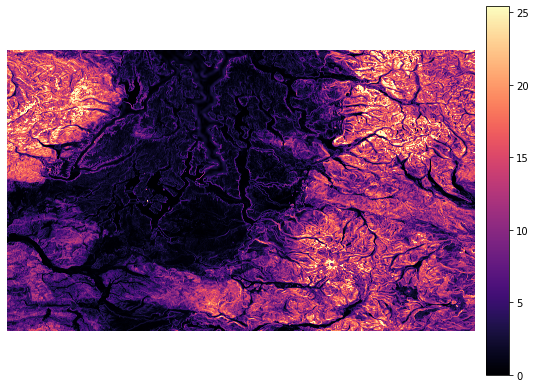

In [19]:
slope = rd.TerrainAttribute(NWWA_dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

## Calculate the aspect (which way is the slope facing?)
Aspect: https://gisgeography.com/aspect-map/

example https://www.earthdatascience.org/tutorials/get-slope-aspect-from-digital-elevation-model/


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.14861


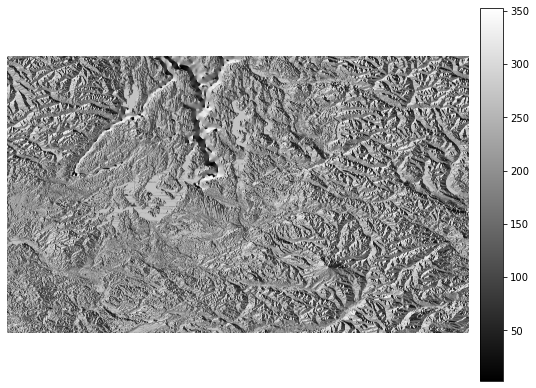

In [33]:
aspect = rd.TerrainAttribute(NWWA_dem, attrib='aspect')

rd.rdShow(aspect, axes=False, figsize=(8, 5.5))
plt.show()

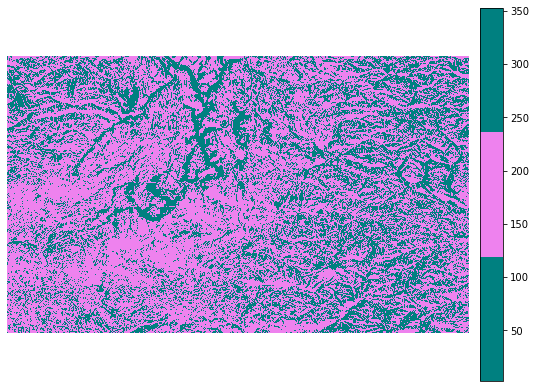

In [34]:
# Next, I would mask out slopes that are not facing south-ish, 
# i.e. where the aspect is greater than 225 deg or less than 135 deg.
# Note that we'll need to add georeferences and a projection eventually

from matplotlib import colors
cmap = colors.ListedColormap(['teal', 'violet', 'teal'])
bounds=[0,180-45, 180+35 ,360]
norm = colors.BoundaryNorm(bounds, cmap.N)

rd.rdShow(aspect, axes=False, cmap=cmap, figsize=(8, 5.5))
plt.show()

In [9]:
southish = np.ma.masked_where((aspect<135) | (aspect>225), aspect)
southish

masked_rdarray(
  data=[[137.2906036376953, --, --, ..., --, --, 223.60281372070312],
        [159.04421997070312, 146.8214874267578, --, ...,
         219.22567749023438, 220.60128784179688, 212.77487182617188],
        [168.6900634765625, 163.1625213623047, 159.85159301757812, ...,
         216.86990356445312, 216.02737426757812, 206.30101013183594],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False,  True,  True, ...,  True,  True, False],
        [False, False,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

***
## Bring in satellite images

Background Reading:
https://www.iges.or.jp/en/publication_documents/pub/peer/en/6898/Ma+et+al+2019.pdf

Data Sources:
Landsat 8 on AWS https://registry.opendata.aws/landsat-8/

Examples:
https://github.com/robmarkcole/satellite-image-deep-learning
https://towardsdatascience.com/neural-network-for-satellite-data-classification-using-tensorflow-in-python-a13bcf38f3e1

Use the Landsat explorer at https://landsatlook.usgs.gov/explore to find the scenes near Seattle. Need to encompass date range from June 1, 2021 - Sept 30, 2021 to get the entire NW washington area covered by at least one pass.

In [10]:
import requests
import itertools

def fetch_sat_api(query):
    '''
    Queries the sat-api (STAC) backend.
    This function handles pagination.
    query is a python dictionary to pass as json to the request.
    '''
    headers = {
        "Content-Type": "application/json",
        "Accept-Encoding": "gzip",
        "Accept": "application/geo+json",
    }

    url = f"https://landsatlook.usgs.gov/sat-api/stac/search"
    data = requests.post(url, headers=headers, json=query).json()
    error = data.get("message", "")
    if error:
        raise Exception(f"SAT-API failed and returned: {error}")

    meta = data.get("meta", {})
    if not meta.get("found"):
        return []
    print(meta)

    features = data["features"]
    if data["links"]:
        curr_page = int(meta["page"])
        query["page"] = curr_page + 1
        query["limit"] = meta["limit"]

        features = list(itertools.chain(features, fetch_sat_api(query)))

    return features

query = {"bbox":[-126.5625,45.08903556483103,-118.125,50.73645513701065],"query":{"collections":["landsat-c2l2-sr","landsat-c2l2-st"],"eo:cloud_cover":{"lte":25},"platform":{"in":["LANDSAT_8"]},"landsat:collection_category":{"in":["T1","T2","RT"]}},"time":"2021-06-01T00:00:00.000/2021-09-30T23:59:59.999","limit":700}

features = fetch_sat_api(query)

{'page': 1, 'limit': 700, 'found': 212, 'returned': 212}
